#### 6

In [1]:
library(forecast)
library(ggplot2)
library(dplyr)
library(gridExtra)


Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Attaching package: ‘gridExtra’

The following object is masked from ‘package:dplyr’:

    combine



In [2]:
# library(doParallel)
library(doMC)
options(cores = 10)
registerDoMC()

Loading required package: foreach
Loading required package: iterators
Loading required package: parallel


### ЕС

In [3]:
df_eu  <-  read.csv(file="../data_hts/hts_eu_a10.csv", header=TRUE, sep=",", row.names =1 )
df_eu  <-  df_eu/1000
var_freq  <- 4    
var_start_year  <- 2000   
gdp_agg <- df_eu_sums <-  rowSums(df_eu)
gdp_agg  <- ts(gdp_agg, frequency = var_freq, start = var_start_year) 

In [4]:
var_h  <- 8
var_window  <-  48 - 1
var_topup  <-  1
var_iter   <- (length(gdp_agg)+var_topup)/var_freq-(var_window+1)/var_freq-2

In [5]:
# var_allornot  <- var_freq
var_allornot  <- 1
# var_shift  <-  var_topup
var_shift  <-  0

In [6]:
var_arpdq   <-  c(3,1,1)
var_sarpdq   <-  c(2,1,1)
var_drift   <-  FALSE
var_constant   <-  FALSE

In [7]:
l <- ac <- m_top  <- l_test  <-  list()

k  <- 0

for (i in 0:(var_iter*var_allornot - var_shift)){
    k  <-  k+1
    st_year  <-  var_start_year + i/var_allornot
    train_start  <- st_year 
    train_end  <- st_year + 1/var_freq*(var_window)
    test_start  <- st_year + 1/var_freq*(var_window+1) 
    test_end  <-  st_year + 1/var_freq*(var_window+var_h)
    
    print(c(train_start, train_end, test_start, test_end))
    
    if (i == 0){
        train <- window(gdp_agg, end=train_end)}
    else{
        if ((var_shift == 0) & (i == var_iter*var_allornot - var_shift)){
            train <- window(gdp_agg, start=train_start-var_topup/var_freq, end=train_end-var_topup/var_freq)
        }else{
            train <- window(gdp_agg, start=train_start, end=train_end)
    }}
    
    if ((var_shift == 0) & (i == var_iter*var_allornot - var_shift)){
        test <- window(gdp_agg, start=test_start-var_topup/var_freq)
    }else{    test <- window(gdp_agg, start=test_start, end=test_end)
        
    }
    
    m_top[[k]]  <- Arima(msts(train, seasonal.periods = var_freq), order=var_arpdq, seasonal=var_sarpdq, include.drift = var_drift, include.mean = var_constant, method="ML")
    
#     print(test)
#     print(gdp_arima)
    l[[k]]  <-   forecast(m_top[[k]], h = var_h  )

    l_test[[i+1]]  <-   test
    
    ac[[i+1]]  <-  accuracy(l[[k]], test)

    }

[1] 2000.00 2011.75 2012.00 2013.75
[1] 2001.00 2012.75 2013.00 2014.75
[1] 2002.00 2013.75 2014.00 2015.75
[1] 2003.00 2014.75 2015.00 2016.75
[1] 2004.00 2015.75 2016.00 2017.75
[1] 2005.00 2016.75 2017.00 2018.75


In [8]:
var_acc_metrics  <-  c(1,2,5)
df_acc_test  <- ac[[1]][2, var_acc_metrics]
for (i in ac[2:length(ac)]){
    x  <-  i[2, var_acc_metrics]
    df_acc_test   <-  cbind(df_acc_test, x)
}
df_acc_test  <- t(df_acc_test)
df_acc_test  <-  as.data.frame(df_acc_test)
row.names(df_acc_test)  <-  seq(1,length(ac))
df_acc_test

ME,RMSE,MAPE
60.48571,61.90900,1.990478
36.86536,52.21238,1.269950
61.95016,74.86362,1.878502
72.72526,76.00259,2.180301
-66.95728,73.02833,1.985293
149.12562,156.76499,4.286335


In [9]:
colMeans(df_acc_test)

ME      RMSE      MAPE 
52.365803 82.463486  2.265143

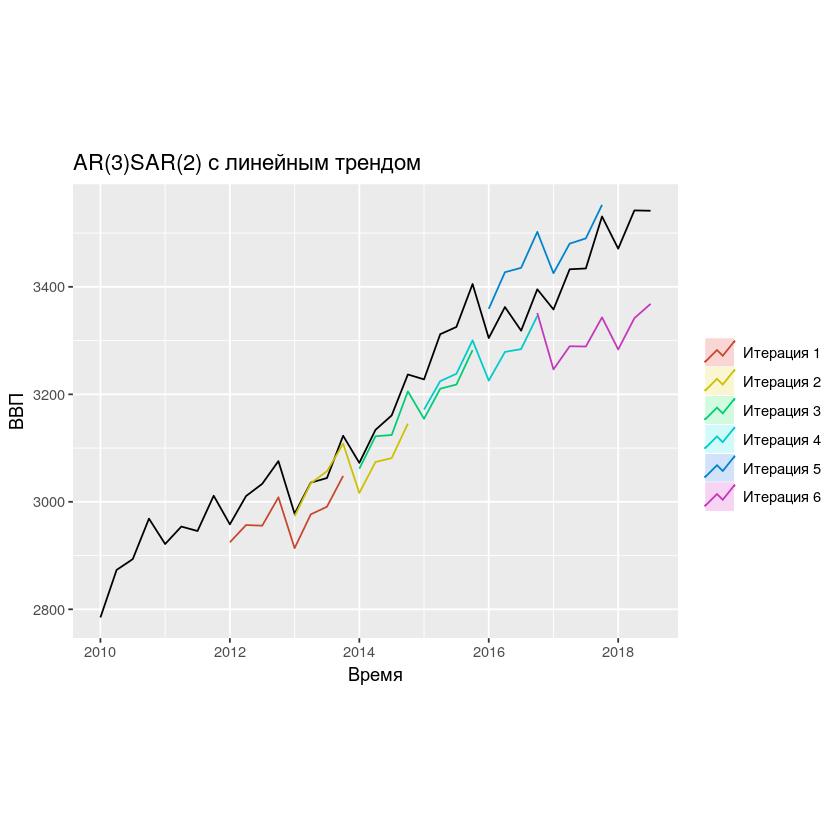

In [10]:
plot_forecasts  <-  autoplot(window(gdp_agg, start=2010))+
    xlab("Время") + ylab('ВВП') +
    ggtitle("AR(3)SAR(2) с линейным трендом") +
    guides(colour=guide_legend(title=" ")) +
    theme(aspect.ratio = 0.75)

for (i in 1:length(l)){
    plot_forecasts  <-  plot_forecasts  +
    autolayer(l[[i]], series=paste("Итерация" , i, sep=" ") ,   PI=FALSE) 
    
}

plot_forecasts


In [11]:
df_mean_acc <- readRDS("df_mean_acc.rds")
df_mean_acc

,Квартальные,Сезонно сглаженные,Месячные
1 level,82.46349,320.025,11447.11
2,NA,NA,NA
3,NA,NA,NA
4,NA,NA,NA
5,NA,NA,NA


In [12]:
df_mean_acc[1,1]  <-  colMeans(df_acc_test)[[2]]
df_mean_acc

,Квартальные,Сезонно сглаженные,Месячные
1 level,82.46349,320.025,11447.11
2,NA,NA,NA
3,NA,NA,NA
4,NA,NA,NA
5,NA,NA,NA


In [13]:
save_plots  <- list()

In [14]:
save_plots[[1]]  <-  plot_forecasts

In [15]:
df_acc  <-  df_acc_test

In [16]:
colnames(df_acc)  <-  colnames(ac[[1]])[var_acc_metrics] 
df_acc  <-  cbind(df_acc, seq(1, length(ac)))
colnames(df_acc)[length(var_acc_metrics)+1]  <-  'Iteration'

In [17]:
df_acc$Iteration  <-  df_acc$Iteration*var_freq-(var_freq-1)
df_acc$Iteration[length(df_acc$Iteration)]  <-   df_acc$Iteration[length(df_acc$Iteration)] - var_topup

In [18]:
df_acc

ME,RMSE,MAPE,Iteration
60.48571,61.90900,1.990478,1
36.86536,52.21238,1.269950,5
61.95016,74.86362,1.878502,9
72.72526,76.00259,2.180301,13
-66.95728,73.02833,1.985293,17
149.12562,156.76499,4.286335,20


In [19]:
var_allornot  <- var_freq
# var_allornot  <- 1
var_shift  <-  var_topup
# var_shift  <-  0

### США

In [20]:
df_eu  <-  read.csv(file="../data_hts/hts_us_ind_filled.csv", header=TRUE, sep=",", row.names =1 )
df_eu  <-  df_eu/1000
var_freq  <- 4    
var_start_year  <- 2005   
gdp_agg <- df_eu_sums <-  rowSums(df_eu)
gdp_agg  <- ts(gdp_agg, frequency = var_freq, start = var_start_year) 

In [21]:
var_h  <- 8
var_window  <-  28 - 1
var_topup  <-  2
var_iter   <- (length(gdp_agg)+var_topup)/var_freq-(var_window+1)/var_freq-2

In [22]:
# var_allornot  <- var_freq
var_allornot  <- 1
# var_shift  <-  var_topup
var_shift  <-  0

var_arpdq   <-  c(4,1,1)
var_sarpdq   <-  c(0,0,0)
var_drift   <-  FALSE
var_constant   <-  FALSE

In [23]:
l <- ac <- m_top  <- l_test  <-  list()

k  <- 0

for (i in 0:(var_iter*var_allornot - var_shift)){
    k  <-  k+1
    st_year  <-  var_start_year + i/var_allornot
    train_start  <- st_year 
    train_end  <- st_year + 1/var_freq*(var_window)
    test_start  <- st_year + 1/var_freq*(var_window+1) 
    test_end  <-  st_year + 1/var_freq*(var_window+var_h)
    
    print(c(train_start, train_end, test_start, test_end))
    
    if (i == 0){
        train <- window(gdp_agg, end=train_end)}
    else{
        if ((var_shift == 0) & (i == var_iter*var_allornot - var_shift)){
            train <- window(gdp_agg, start=train_start-var_topup/var_freq, end=train_end-var_topup/var_freq)
        }else{
            train <- window(gdp_agg, start=train_start, end=train_end)
    }}
    
    if ((var_shift == 0) & (i == var_iter*var_allornot - var_shift)){
        test <- window(gdp_agg, start=test_start-var_topup/var_freq)
    }else{    test <- window(gdp_agg, start=test_start, end=test_end)
        
    }
    
    m_top[[k]]  <- Arima(msts(train, seasonal.periods = var_freq), order=var_arpdq, seasonal=var_sarpdq, include.drift = var_drift, include.mean = var_constant, method="ML")
    
#     print(test)
#     print(gdp_arima)
    l[[k]]  <-   forecast(m_top[[k]], h = var_h  )

    l_test[[i+1]]  <-   test
    
    ac[[i+1]]  <-  accuracy(l[[k]], test)
    
    }

[1] 2005.00 2011.75 2012.00 2013.75
[1] 2006.00 2012.75 2013.00 2014.75
[1] 2007.00 2013.75 2014.00 2015.75
[1] 2008.00 2014.75 2015.00 2016.75
[1] 2009.00 2015.75 2016.00 2017.75
[1] 2010.00 2016.75 2017.00 2018.75


In [24]:
var_acc_metrics  <-  c(1,2,5)
df_acc_test  <- ac[[1]][2, var_acc_metrics]
for (i in ac[2:length(ac)]){
    x  <-  i[2, var_acc_metrics]
    df_acc_test   <-  cbind(df_acc_test, x)
}
df_acc_test  <- t(df_acc_test)
df_acc_test  <-  as.data.frame(df_acc_test)
row.names(df_acc_test)  <-  seq(1,length(ac))
df_acc_test

ME,RMSE,MAPE
155.89339,218.57930,0.9601140
607.49665,686.82496,3.6746079
410.89331,501.70493,2.5607291
358.89312,391.41444,2.0782358
12.01051,43.83413,0.1906769
35.63698,77.79248,0.3377620


In [25]:
colMeans(df_acc_test)

ME       RMSE       MAPE 
263.470661 320.025041   1.633688

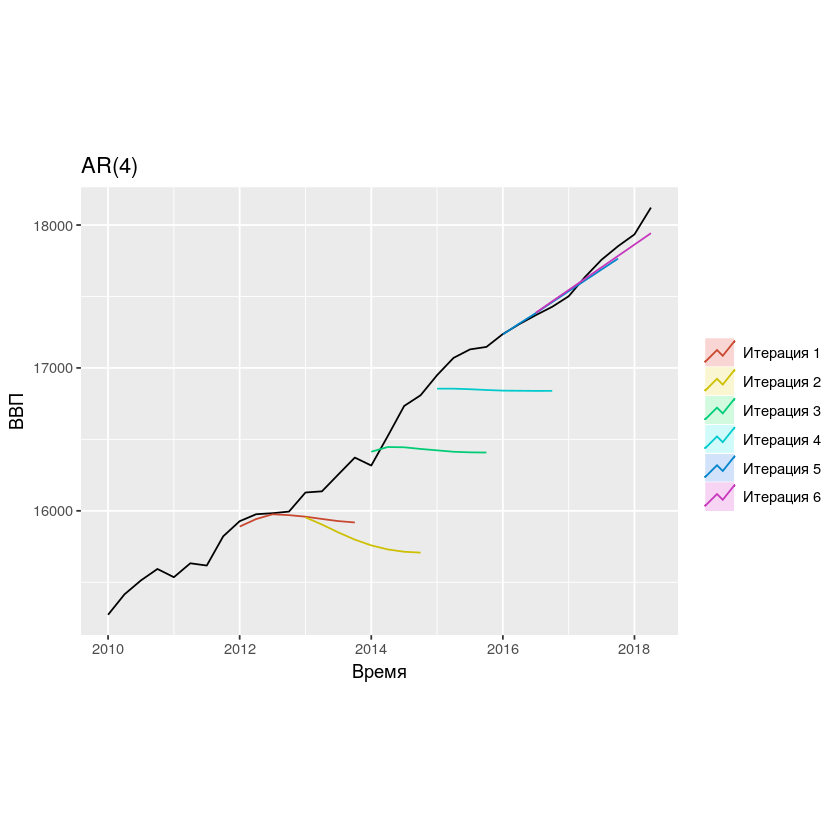

In [26]:
plot_forecasts  <-  autoplot(window(gdp_agg, start=2010))+
    xlab("Время") + ylab('ВВП') +
    ggtitle("AR(4)") +
    guides(colour=guide_legend(title=" ")) +
    theme(aspect.ratio = 0.75)

for (i in 1:length(l)){
    plot_forecasts  <-  plot_forecasts  +
    autolayer(l[[i]], series=paste("Итерация" , i, sep=" ") ,   PI=FALSE) 
    
}

plot_forecasts


In [27]:
df_mean_acc[1,2]  <- colMeans(df_acc_test)[[2]]
df_mean_acc

,Квартальные,Сезонно сглаженные,Месячные
1 level,82.46349,320.025,11447.11
2,NA,NA,NA
3,NA,NA,NA
4,NA,NA,NA
5,NA,NA,NA


In [28]:
save_plots[[3]]  <-  plot_forecasts

In [29]:
var_allornot  <- var_freq
# var_allornot  <- 1
var_shift  <-  var_topup
# var_shift  <-  0

### РФ

In [30]:
df_eu  <-  read.csv(file="../data_hts/hts_rus_summed.csv", header=TRUE, sep=",", row.names =1 )
# df_eu  <-  df_eu/1000
var_freq  <- 12    
var_start_year  <- 2006   
gdp_agg <- df_eu_sums <-  rowSums(df_eu)
gdp_agg  <- ts(gdp_agg, frequency = var_freq, start = var_start_year) 

In [31]:
var_h  <- 24
var_window  <-  84 - 1
var_topup  <-  -1
var_iter   <- (length(gdp_agg)+var_topup)/var_freq-(var_window+1)/var_freq-2

In [32]:
# var_allornot  <- var_freq
var_allornot  <- 1
# var_shift  <-  var_topup
var_shift  <-  0

var_arpdq   <-  c(4,1,1)
var_sarpdq   <-  c(1,1,1)
var_drift   <-  FALSE
var_constant   <-  FALSE

In [33]:
require(svMisc)

Loading required package: svMisc

Attaching package: ‘svMisc’

The following object is masked from ‘package:utils’:

    ?



In [34]:
l <- ac <- m_top  <- l_test  <-  list()

k  <- 0
err_list  <- c()
for (i in 0:(var_iter*var_allornot - var_shift)){
    k  <-  k+1
    st_year  <-  var_start_year + i/var_allornot
    train_start  <- st_year 
    train_end  <- st_year + 1/var_freq*(var_window)
    test_start  <- st_year + 1/var_freq*(var_window+1) 
    test_end  <-  st_year + 1/var_freq*(var_window+var_h)
    
#     print(c(train_start, train_end, test_start, test_end))
    
    if (i == 0){
        train <- window(gdp_agg, end=train_end)}
    else{
#         if ((var_shift == 0) & (i == var_iter*var_allornot - var_shift)){
#             train <- window(gdp_agg, start=train_start-var_topup/var_freq, end=train_end-var_topup/var_freq)
#         }else{
            train <- window(gdp_agg, start=train_start, end=train_end)
#     }
}
    
#     if ((var_shift == 0) & (i == var_iter*var_allornot - var_shift)){
#         test <- window(gdp_agg, start=test_start-var_topup/var_freq)
#     }else{    
        test <- window(gdp_agg, start=test_start, end=test_end)
        
#     }
    
#     m_top[[k]]  <- Arima(train, order=var_arpdq, seasonal=var_sarpdq, include.drift = var_drift, include.mean = var_constant, 
#                          method = "ML" )
    
#     model  <-  
    m_top[[k]]  <-Arima(msts(train, seasonal.periods = var_freq), order=var_arpdq, seasonal=var_sarpdq, include.drift = var_drift, include.mean = var_constant, method="ML")

    
    
#     print(test)
#     print(gdp_arima)
    l[[k]]  <-   forecast(m_top[[k]], h = var_h  )
                
#     if (model[[2]]!=0){
#         err_list <-  c(err_list,model[[2]])
#     }              
                
                
    l_test[[i+1]]  <-   test
    
    ac[[i+1]]  <-  accuracy(l[[k]], test)
                
    progress(i, progress.bar = TRUE)
    
    
                
    }

          0%---------25%---------50%---------75%--------100%
Progress: ||

In [35]:
var_acc_metrics  <-  c(1,2,5)
df_acc_test  <- ac[[1]][2, var_acc_metrics]
for (i in ac[2:length(ac)]){
    x  <-  i[2, var_acc_metrics]
    df_acc_test   <-  cbind(df_acc_test, x)
}
df_acc_test  <- t(df_acc_test)
df_acc_test  <-  as.data.frame(df_acc_test)
row.names(df_acc_test)  <-  seq(1,length(ac))
df_acc_test

ME,RMSE,MAPE
-9997.647,12111.647,517.0143
-9635.972,11330.689,266.1900
-7421.280,10391.004,169.3956
-17113.605,19515.044,306.1013
-4817.195,8021.594,81.0338


In [36]:
colMeans(df_acc_test)

ME      RMSE      MAPE 
-9797.140 12273.995   267.947

In [37]:
err_list

NULL

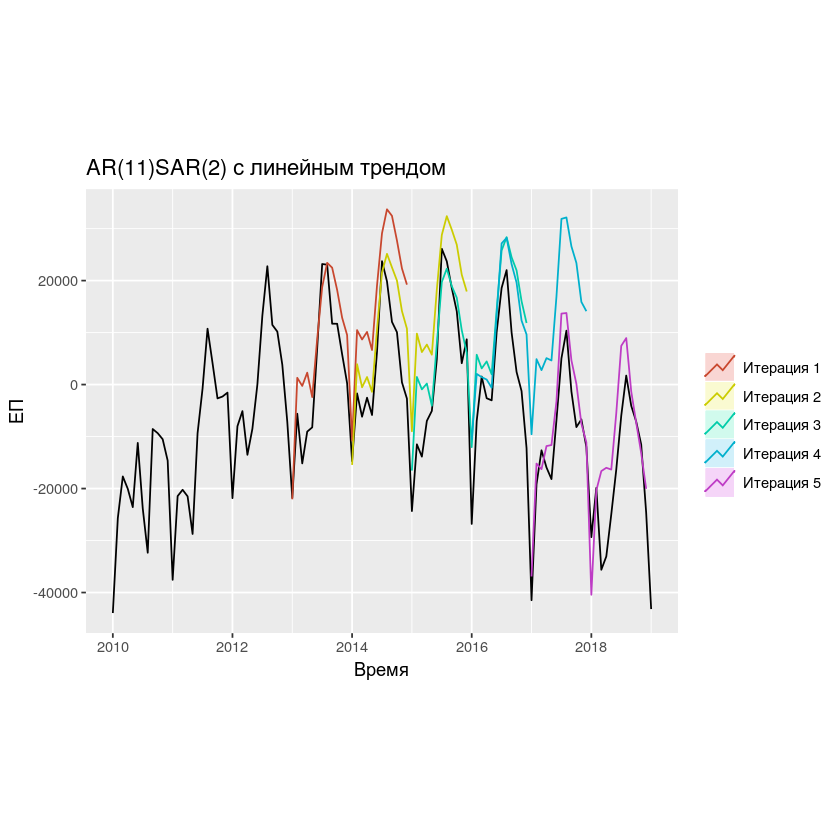

In [38]:
plot_forecasts  <-  autoplot(window(gdp_agg, start=2010))+
    xlab("Время") + ylab('ЕП') +
    ggtitle("AR(11)SAR(2) с линейным трендом") +
    guides(colour=guide_legend(title=" ")) +
    theme(aspect.ratio = 0.75)

for (i in 1:length(l)){
    plot_forecasts  <-  plot_forecasts  +
    autolayer(l[[i]], series=paste("Итерация" , i, sep=" ") ,   PI=FALSE) 
    
}

plot_forecasts


In [39]:
df_mean_acc

,Квартальные,Сезонно сглаженные,Месячные
1 level,82.46349,320.025,11447.11
2,NA,NA,NA
3,NA,NA,NA
4,NA,NA,NA
5,NA,NA,NA


In [40]:
df_mean_acc[1,3]  <- colMeans(df_acc_test)[[2]]
df_mean_acc

,Квартальные,Сезонно сглаженные,Месячные
1 level,82.46349,320.025,12274
2,NA,NA,NA
3,NA,NA,NA
4,NA,NA,NA
5,NA,NA,NA


In [41]:
save_plots[[5]]  <-  plot_forecasts

In [42]:
var_allornot  <- var_freq
# var_allornot  <- 1
var_shift  <-  var_topup
# var_shift  <-  0

In [43]:
df_mean_acc

,Квартальные,Сезонно сглаженные,Месячные
1 level,82.46349,320.025,12274
2,NA,NA,NA
3,NA,NA,NA
4,NA,NA,NA
5,NA,NA,NA


In [44]:
saveRDS(df_mean_acc, "df_mean_acc.rds")